In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [2]:
def seq2seq_window_dataset(series, window_size, batch_size=10,
                           shuffle_buffer=10):
    series = tf.expand_dims(series, axis=-1)  # expand dimention of matrix, axis=-1 means last axis(column)
    ds = tf.data.Dataset.from_tensor_slices(series).repeat(4)  # creates a dataset with a separate element for each row of the input tensor
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [3]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(16).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
# reading the dataset
df = pd.read_csv(r"C:\Users\joy\Desktop\Sea Level\data\csiro_alt_gmsl_mo_2015_csv_edited.csv")
df['id'] = df.index
time = df.index
series = df.GMSL

In [5]:
# setting up dataset
split = 180
xTrain = time[:split]
yTrain = series[:split]
xTest = time[split:]
yTest = series[split:]

window_size = 5
train_set = seq2seq_window_dataset(yTrain, window_size)

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1])) # unknown rows, 1 column

for dilation_rate in (1, 2, 4, 8):
    model.add(keras.layers.Conv1D(filters=32, # number of output filters used in the convolution
                                  kernel_size=2, # Specifies the size of the convolutional window
                                  strides=1, # specifying the shift size
                                  dilation_rate=dilation_rate,
                                  padding="causal", # convolution output can be the same size as the input
                                  activation="relu"))
# model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(25, activation="relu"))
model.add(keras.layers.Dense(1))


optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

trained = model.fit(train_set, epochs=50)

Epoch 1/50
72/72 [==============================] - 0s 4ms/step - loss: 23.7561 - mae: 24.2403
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 22.2048 - mae: 22.6898
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 10.6675 - mae: 11.1556
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 4.3291 - mae: 4.7990
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 3.5387 - mae: 3.9966
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 3.0499 - mae: 3.5116
Epoch 7/50
72/72 [==============================] - 0s 2ms/step - loss: 2.7409 - mae: 3.2071
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: 2.6759 - mae: 3.1411
Epoch 9/50
72/72 [==============================] - 0s 2ms/step - loss: 2.5949 - mae: 3.0557
Epoch 10/50
72/72 [==============================] - 0s 2ms/step - loss: 2.6081 - mae: 3.0727
Epoch 11/50
72/72 [==============================] - 0s 2ms/ste

In [7]:
cnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
#print(cnn_forecast)
cnn_forecast = cnn_forecast[split - window_size:-1, -1, 0]
print(cnn_forecast)

[45.43327  44.215664 46.479244 45.69838  49.0781   49.10335  52.782
 49.680485 49.802425 48.970463 49.946693 49.678356 50.84271  50.523182
 51.171406 51.27068  53.929203 52.96474  55.12591  54.651978 54.415012
 54.243336 55.483547 55.185654 55.847946 55.220016 53.678715 55.611248
 55.67931  56.961567 58.946033 59.852524 57.177982 55.26893  53.382378
 54.376934 52.67494  53.59324  52.895504 52.633327 51.556366 53.92673
 54.44196  57.0124   55.45075  57.38799  55.45763  57.672882 56.67643
 61.798862 63.50308  62.22795  62.752846 63.29092  65.53366  67.947334
 68.20157  66.000336 66.84524  66.98544  68.26834  69.708    69.514275
 69.089386 70.7869   68.6859   69.76044  68.857895 68.77348  65.60407
 66.78626  66.560074 68.193115 67.696815 69.8255   70.75233  70.96356
 69.76881  71.275696 72.69278  73.33952  72.61232  71.105865 71.82843
 71.73247        nan]


<IPython.core.display.Javascript object>


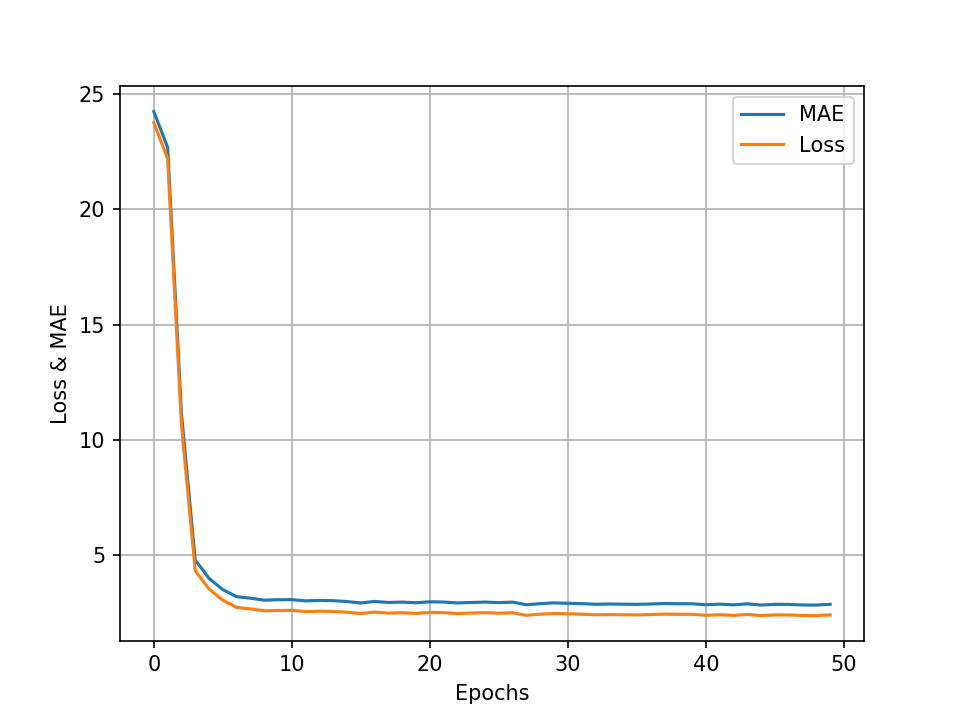

In [12]:
%matplotlib notebook
# plotting
plt.plot(trained.history['mae'], label="MAE")
plt.plot(trained.history['loss'], label="Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss & MAE")
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


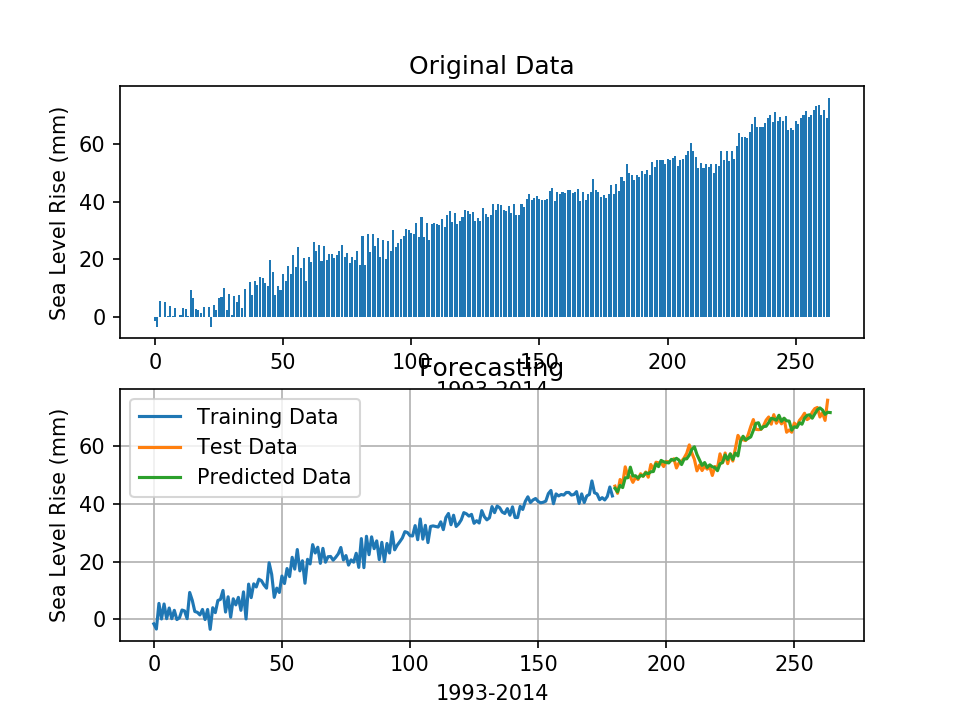

In [13]:
%matplotlib notebook
fig, axs = plt.subplots(2)
plt.grid(True)

axs[0].bar(time, series, alpha=1)
axs[0].set(ylabel='Sea Level Rise (mm)', xlabel='1993-2014', title="Original Data")

axs[1].plot(xTrain, yTrain, label='Training Data')
axs[1].plot(xTest, yTest, label='Test Data')
axs[1].plot(xTest, cnn_forecast, label='Predicted Data')
axs[1].legend(loc='upper left', frameon=True)
axs[1].set(ylabel='Sea Level Rise (mm)', xlabel='1993-2014', title="Forecasting")
plt.show()

In [10]:
# error calculation
errors = cnn_forecast - yTest
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print("Mean Absolute Error", mae)

Mean Absolute Error 1.589820325942266


<IPython.core.display.Javascript object>


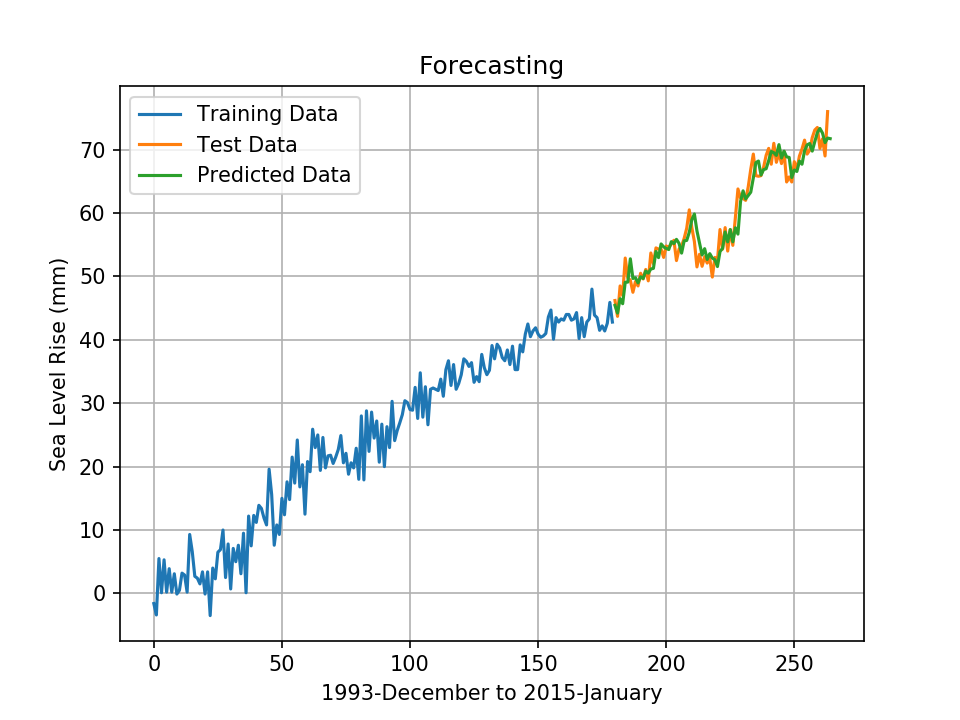

In [11]:
%matplotlib notebook
# forecasting plot
fig, axs = plt.subplots(1)
plt.grid(True)
axs.plot(xTrain, yTrain, label='Training Data')
axs.plot(xTest, yTest, label='Test Data')
axs.plot(xTest, cnn_forecast, label='Predicted Data')
axs.legend(loc='upper left', frameon=True)
axs.set(ylabel='Sea Level Rise (mm)', xlabel='1993-December to 2015-January', title="Forecasting")

plt.show()